In [121]:
#import library for getting folders
import glob

#import library for dataframe
import pandas as pd
import numpy as np
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd

############# Libraries for Natural Language Processing #############
#Libraries used for Pre-Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Library for sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import requests
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer

#######################################################

import re

#Library for visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Setting GitHub Credentials

In [122]:
username = "GreyScaling"
repo_name = "UOB-Financial-Loan-Analysis"

# Specify the folder path (e.g., "path/to/folder")
folder_path = "csvs"

In [123]:
def get_filenames(username , repo_name , folder_path):

    '''

    Takes in the github credentials and returns the csv filenames within the folder given
    
    Parameters: 
        username (str): GitHub Username
        repo_name (str): User's Repository Name
        folder_path (str): The folder path containing the csv files
           
    Returns:

        filenames (list) : Returns a list of csv folderpaths    
     '''

    url = f"https://api.github.com/repos/{username}/{repo_name}/contents/{folder_path}"
    csv_path = f'https://raw.githubusercontent.com/{username}/{repo_name}/main/{folder_path}/'


    filenames = []
    response = requests.get(url)

    #Checks if the url is OK
    if response.status_code == 200:
        data = response.json()
        for item in data:
            # Check if the item is a file and ends with ".csv" extension
            if item["type"] == "file" and item["name"].endswith(".csv"):

                #Attach the folder path together with the filename get the entire url  
                filename = csv_path + item['name']
                filenames.append(filename)
    else:
        print(f"Error: {response.status_code}")

    return(filenames)

In [124]:
print(get_filenames.__doc__)



    Takes in the github credentials and returns the csv filenames within the folder given
    
    Parameters: 
        username (str): GitHub Username
        repo_name (str): User's Repository Name
        folder_path (str): The folder path containing the csv files
           
    Returns:

        filenames (list) : Returns a list of csv folderpaths    
     


In [125]:
#Return a list of the filepaths
csvs = get_filenames(username , repo_name , folder_path)

In [126]:
#Read all the files into a single dataframe
df = dd.read_csv(csvs).compute().reset_index(drop=True)

In [127]:
#Remove any row that has no content 
df = df[df['Content'].str.strip() != '']
#Remove any null Rows 
df.dropna(inplace =True)

In [128]:
def lemmatize_words(text):
    """ function to lemmatize the words"""    
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(' ')])

In [129]:
def pre_process(dataframe):
    '''
    This Function performs the pre-processing of the dataframe 

    args:
        dataframe: The dataframe to be preprocessed
    
    Functions:
        
        the following are the steps taken to proprocess the data

        1) Lower case tranformation
        2) Removing Stopwords
        3) Removing single alphabets
        4) Removing WhiteSpace
        5) Removing Punctuations
        6) Removing Emojis & other image related symbolds
        7) Lemmatizing the words

    '''
    
    #converts text to lowercase
    dataframe['Content'] = dataframe['Content'].apply(lambda x: x.lower())

    #Remove all punctuations
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('[^\w\s]', ' ', x))

    #Remove all stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'singapore', 'malaysia' , 'said' ,','])
    dataframe['Content'] = dataframe['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

    #Removing Numbers
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\d+' , '' , x))

    #remove single alphabets
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\b[a-zA-Z]\s', ' ' , x))

    #remove Hyperlinks
    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("<.*?>+|https?://\S+|www\.\S+", " " , x))

    dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub("/^\s+|\s+$|\s+(?=\s)/g", "" , x))


    #Removing Emojis and any other image related symbols
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoji
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)
    
    dataframe['Content'] = dataframe['Content'].apply(lambda x: emoji_pattern.sub(r' ', x))

    #Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    dataframe['Content'] = dataframe['Content'].apply(lambda x:" ".join([lemmatizer.lemmatize(word) for word in x.split(' ')]) ) 



<>:26: SyntaxWarning: invalid escape sequence '\w'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\S'
<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\w'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\S'
<>:42: SyntaxWarning: invalid escape sequence '\s'
/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_1962/150253469.py:26: SyntaxWarning: invalid escape sequence '\w'
  dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('[^\w\s]', ' ', x))
/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_1962/150253469.py:34: SyntaxWarning: invalid escape sequence '\d'
  dataframe['Content'] = dataframe['Content'].apply(lambda x: re.sub('\d+' , '' , x))
/var/folders/y_/8gyd3ykj37j086_rbgg_6yn00000gn/T/ipykernel_1962/1

In [130]:
pre_process(df)

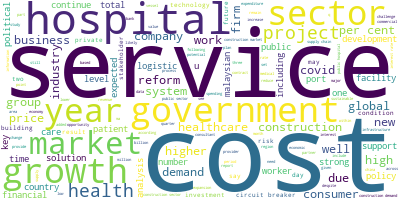

In [131]:
# Join the different processed titles together.
long_string = ','.join(list(df['Content'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [132]:
def get_top_n_words(n_top_words, text_data):
    '''
    Returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample

    Args:
    - n_top_words (int): Number of top words to retrieve
    - text_data (pandas.Series): Series containing text data
    
    Returns:
    - tuple: A tuple containing two elements:
             1. List of top n words
             2. List of counts corresponding to the top n words
    '''
    # Initialize CountVectorizer
    count_vectorizer = CountVectorizer(stop_words='english')
    
    # Vectorize the headlines
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    
    # Sum up the vectorized words
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    
    # Get indices of sorted words
    word_indices = np.flip(np.argsort(vectorized_total)[0, :], 1)
    
    # Get sorted word counts
    word_values = np.flip(np.sort(vectorized_total)[0, :], 1)
    
    # Initialize word vectors
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    
    # Populate word vectors
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    # Get words from indices
    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0, :n_top_words].tolist()[0])


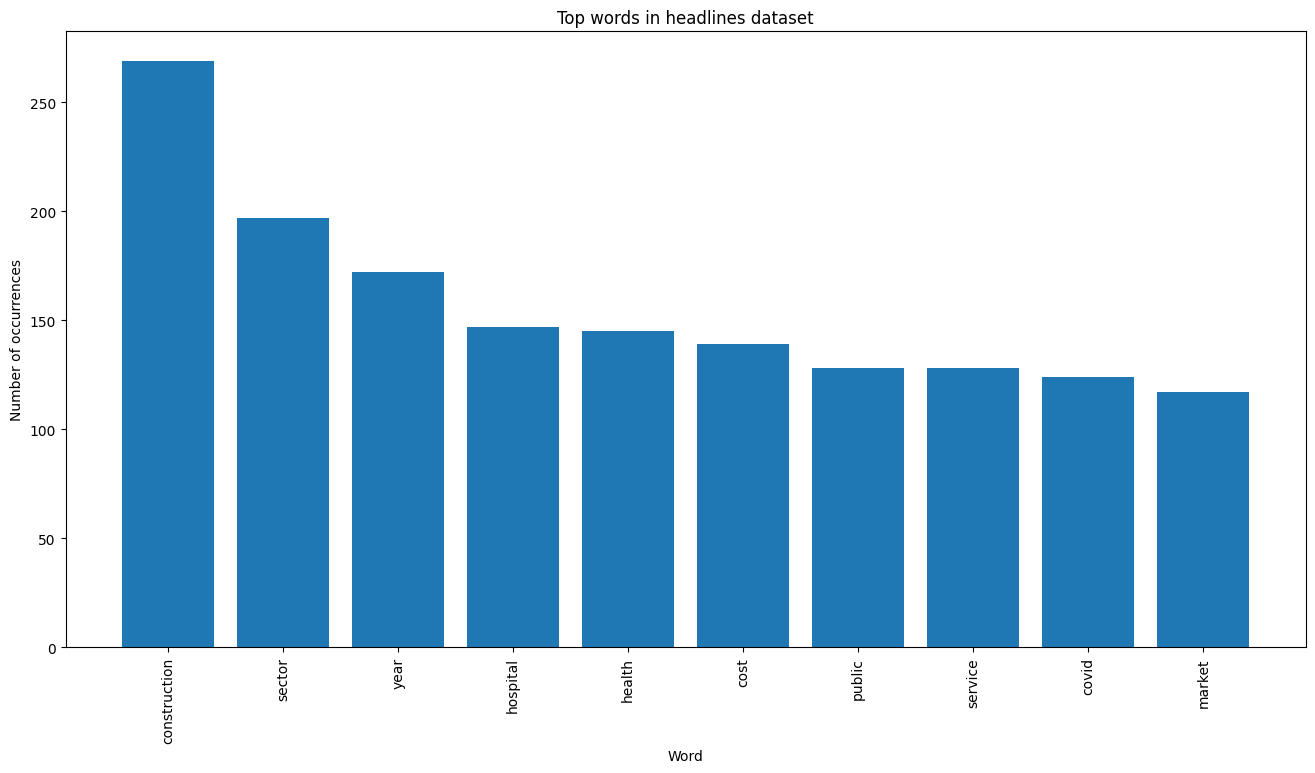

In [133]:
# Get the top n words and their counts
words, word_values = get_top_n_words(n_top_words=10, text_data=df['Content'])

# Plot the top words
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurrences')
plt.show()


In [134]:
headlines_array = np.array(df['Content'])
headlines_list = list(headlines_array)

In [135]:
def sentiment_dataframe(original_df, predictions):
    

    #Headline #Positive #Negative #Neutral
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {
            "Positive":positive,
            "Negative":negative, 
            "Neutral":neutral
            }
    
    table_df = pd.DataFrame(table)
        
    dataframe = pd.concat([original_df, table_df], axis=1)

    return dataframe

In [136]:
def get_sentiments(original_df, pretrained_model):
    """
    Analyzes the sentiment of a list of headlines using a pre-trained transformer model.

    Args:
        pretrained_model (str): Name of the pre-trained model from the Hugging Face model hub.

    Returns:
        dataFrame: A DataFrame containing the sentiment analysis results.

        """

    # Load pre-trained tokenizer and model for sentiment classification
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)

    # Prepare text inputs with padding, truncation, and conversion to PyTorch tensors
    inputs = tokenizer(headlines_list, padding=True, truncation=True, return_tensors="pt")

    # Get model predictions (logits) and apply softmax for probability distribution
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Create DataFrame to present sentiment analysis results using 'sentiment_dataframe' function
    dataframe = sentiment_dataframe(original_df, predictions)

    return dataframe


In [137]:
finbert_sentiments = get_sentiments(df, "ProsusAI/finbert")
financial_sentiments = get_sentiments(df,"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
sigma_sentiments = get_sentiments(df, "Sigma/financial-sentiment-analysis")

In [138]:
def get_sentimentsII(row, pipeline):
    '''
    Analyzes the sentiment of a content row using a pre-defined sentiment analysis pipeline.

    Args:
    - row (pandas.Series): Row containing the content to analyze
    - pipeline: Pre-defined sentiment analysis pipeline

    Returns:
    - pandas.Series: Updated row with sentiment analysis results added as 'sentiment' and 'sentiment_score'
    '''
    # Extract content from the row
    content = row['Content']
    
    # Perform sentiment analysis using the provided pipeline
    result = pipeline(content)
    
    # Add sentiment analysis results to the row
    row['sentiment'] = result[0]['label']
    row['sentiment_score'] = result[0]['score']
    
    return row


In [139]:
# Define a sentiment analysis pipeline using the "soleimanian/financial-roberta-large-sentiment" model
soleimanian_pipeline = pipeline("sentiment-analysis", 
                                model="soleimanian/financial-roberta-large-sentiment", 
                                tokenizer="soleimanian/financial-roberta-large-sentiment", 
                                max_length=512, 
                                truncation=True)

# Define a sentiment analysis pipeline using the "yiyanghkust/finbert-tone" model
yiyangkhust_pipeline = pipeline("sentiment-analysis", 
                                model="yiyanghkust/finbert-tone", 
                                tokenizer="yiyanghkust/finbert-tone", 
                                max_length=512, 
                                truncation=True)


In [140]:
soleimanian_sentiments = df.apply(get_sentimentsII, pipeline=soleimanian_pipeline, axis=1)
yiyangkhost_sentiments = df.apply(get_sentimentsII, pipeline=yiyangkhust_pipeline, axis=1)

In [141]:
soleimanian_sentiments.head()

,Unnamed: 0,Title,Content,Site-Name,Sector,Country,sentiment,sentiment_score
0,0.0,\nSteady Demand for the Construction Sector Pr...,total construction demand projected billion ...,bca,Construction,Singapore,positive,0.997357
1,0.0,\n BRC Asia posts 2% fall in H2 net pro...,steel solution provider brc asia posted per c...,businesstimes,Construction,Singapore,negative,0.998361
2,1.0,"\n Sluggish loan growth, economic uncer...",rhb research cut weighting banking sector neut...,businesstimes,Financials,Singapore,negative,0.998626
3,2.0,\n Singapore fintech funding dives 41% ...,fintech funding sank three year low first half...,businesstimes,Financials,Singapore,negative,0.995062
4,0.0,\n Some contractors face delays of up to ...,cope heat one company monitoring water intake ...,channelnewsasia,Construction,Singapore,negative,0.998940


In [142]:
yiyangkhost_sentiments.head()

,Unnamed: 0,Title,Content,Site-Name,Sector,Country,sentiment,sentiment_score
0,0.0,\nSteady Demand for the Construction Sector Pr...,total construction demand projected billion ...,bca,Construction,Singapore,Positive,0.998681
1,0.0,\n BRC Asia posts 2% fall in H2 net pro...,steel solution provider brc asia posted per c...,businesstimes,Construction,Singapore,Positive,1.000000
2,1.0,"\n Sluggish loan growth, economic uncer...",rhb research cut weighting banking sector neut...,businesstimes,Financials,Singapore,Positive,0.659527
3,2.0,\n Singapore fintech funding dives 41% ...,fintech funding sank three year low first half...,businesstimes,Financials,Singapore,Positive,0.941291
4,0.0,\n Some contractors face delays of up to ...,cope heat one company monitoring water intake ...,channelnewsasia,Construction,Singapore,Neutral,0.999870


In [143]:
financial_sentiments.head(5)

,Unnamed: 0,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral
0,0.0,\nSteady Demand for the Construction Sector Pr...,total construction demand projected billion ...,bca,Construction,Singapore,0.000168,0.000380,0.999453
1,0.0,\n BRC Asia posts 2% fall in H2 net pro...,steel solution provider brc asia posted per c...,businesstimes,Construction,Singapore,0.997179,0.000200,0.002620
2,1.0,"\n Sluggish loan growth, economic uncer...",rhb research cut weighting banking sector neut...,businesstimes,Financials,Singapore,0.998452,0.000525,0.001024
3,2.0,\n Singapore fintech funding dives 41% ...,fintech funding sank three year low first half...,businesstimes,Financials,Singapore,0.950098,0.000581,0.049321
4,0.0,\n Some contractors face delays of up to ...,cope heat one company monitoring water intake ...,channelnewsasia,Construction,Singapore,0.996161,0.002819,0.001020


In [144]:
sigma_sentiments.head(5)

,Unnamed: 0,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral
0,0.0,\nSteady Demand for the Construction Sector Pr...,total construction demand projected billion ...,bca,Construction,Singapore,0.011217,0.073685,0.915098
1,0.0,\n BRC Asia posts 2% fall in H2 net pro...,steel solution provider brc asia posted per c...,businesstimes,Construction,Singapore,0.994168,0.001929,0.003903
2,1.0,"\n Sluggish loan growth, economic uncer...",rhb research cut weighting banking sector neut...,businesstimes,Financials,Singapore,0.905494,0.046553,0.047953
3,2.0,\n Singapore fintech funding dives 41% ...,fintech funding sank three year low first half...,businesstimes,Financials,Singapore,0.652752,0.105923,0.241325
4,0.0,\n Some contractors face delays of up to ...,cope heat one company monitoring water intake ...,channelnewsasia,Construction,Singapore,0.261216,0.409192,0.329591


In [145]:
finbert_sentiments.head(5)

,Unnamed: 0,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral
0,0.0,\nSteady Demand for the Construction Sector Pr...,total construction demand projected billion ...,bca,Construction,Singapore,0.059065,0.022180,0.918755
1,0.0,\n BRC Asia posts 2% fall in H2 net pro...,steel solution provider brc asia posted per c...,businesstimes,Construction,Singapore,0.111385,0.766795,0.121820
2,1.0,"\n Sluggish loan growth, economic uncer...",rhb research cut weighting banking sector neut...,businesstimes,Financials,Singapore,0.201232,0.733099,0.065669
3,2.0,\n Singapore fintech funding dives 41% ...,fintech funding sank three year low first half...,businesstimes,Financials,Singapore,0.091765,0.193634,0.714601
4,0.0,\n Some contractors face delays of up to ...,cope heat one company monitoring water intake ...,channelnewsasia,Construction,Singapore,0.031225,0.327805,0.640970


In [146]:
def getSentimentLabel(row):
  Positive = row['Positive']
  Negative = row['Negative']
  Neutral = row['Neutral']
  if Positive > Negative and Positive > Neutral:
    return 'Positive'
  elif Negative > Positive and Negative > Neutral:
    return 'Negative'
  else:
    return 'Neutral'
  

In [147]:
financial_sentiments['sentiment'] = financial_sentiments.apply(getSentimentLabel, axis=1)
finbert_sentiments['sentiment'] = finbert_sentiments.apply(getSentimentLabel, axis=1)
sigma_sentiments['sentiment'] = sigma_sentiments.apply(getSentimentLabel, axis=1)

In [148]:
financial_sentiments.head(5)

,Unnamed: 0,Title,Content,Site-Name,Sector,Country,Positive,Negative,Neutral,sentiment
0,0.0,\nSteady Demand for the Construction Sector Pr...,total construction demand projected billion ...,bca,Construction,Singapore,0.000168,0.000380,0.999453,Neutral
1,0.0,\n BRC Asia posts 2% fall in H2 net pro...,steel solution provider brc asia posted per c...,businesstimes,Construction,Singapore,0.997179,0.000200,0.002620,Positive
2,1.0,"\n Sluggish loan growth, economic uncer...",rhb research cut weighting banking sector neut...,businesstimes,Financials,Singapore,0.998452,0.000525,0.001024,Positive
3,2.0,\n Singapore fintech funding dives 41% ...,fintech funding sank three year low first half...,businesstimes,Financials,Singapore,0.950098,0.000581,0.049321,Positive
4,0.0,\n Some contractors face delays of up to ...,cope heat one company monitoring water intake ...,channelnewsasia,Construction,Singapore,0.996161,0.002819,0.001020,Positive


In [149]:
sentiments_dict = {
    "Financial_Sentiments": financial_sentiments,
    "Finbert_Sentiments": finbert_sentiments,
    "Sigma_Sentiments": sigma_sentiments,
    "Soleimanian_Sentiments": soleimanian_sentiments,
    "Yiyangkhost_Sentiments": yiyangkhost_sentiments
}

In [150]:
def combine_sentiments(df, sentiments_dict, column_name="sentiment"):
  '''
  Combines sentiment analysis results from different models into a single DataFrame.

  Args:
  - sentiments_dict (dict): Dictionary containing DataFrames of sentiment analysis results

  Returns:
  - DataFrame: Combined DataFrame containing sentiment analysis results from different models
  '''
    
  map_dict = {
    "Neutral": 0,
    "Positive": 1,
    "Negative": -1,
    'neutral' : 0,
    'positive' : 1,
    'negative' : -1
  }
    
    
  for key, value in sentiments_dict.items():
    df[key] = value[column_name].map(map_dict)
  
  return df
  

In [151]:
df_combined = df.copy()
df_combined = combine_sentiments(df_combined, sentiments_dict)
df_combined.head()

,Unnamed: 0,Title,Content,Site-Name,Sector,Country,Financial_Sentiments,Finbert_Sentiments,Sigma_Sentiments,Soleimanian_Sentiments,Yiyangkhost_Sentiments
0,0.0,\nSteady Demand for the Construction Sector Pr...,total construction demand projected billion ...,bca,Construction,Singapore,0,0,0,1,1
1,0.0,\n BRC Asia posts 2% fall in H2 net pro...,steel solution provider brc asia posted per c...,businesstimes,Construction,Singapore,1,-1,1,-1,1
2,1.0,"\n Sluggish loan growth, economic uncer...",rhb research cut weighting banking sector neut...,businesstimes,Financials,Singapore,1,-1,1,-1,1
3,2.0,\n Singapore fintech funding dives 41% ...,fintech funding sank three year low first half...,businesstimes,Financials,Singapore,1,0,1,-1,1
4,0.0,\n Some contractors face delays of up to ...,cope heat one company monitoring water intake ...,channelnewsasia,Construction,Singapore,1,0,-1,-1,0


In [152]:
df_combined.isna().sum()

Unnamed: 0                0
Title                     0
Content                   0
Site-Name                 0
Sector                    0
Country                   0
Financial_Sentiments      0
Finbert_Sentiments        0
Sigma_Sentiments          0
Soleimanian_Sentiments    0
Yiyangkhost_Sentiments    0
dtype: int64

In [153]:
df_combined.columns

Index(['Unnamed: 0', 'Title', 'Content', 'Site-Name', 'Sector', 'Country',
       'Financial_Sentiments', 'Finbert_Sentiments', 'Sigma_Sentiments',
       'Soleimanian_Sentiments', 'Yiyangkhost_Sentiments'],
      dtype='object')

In [154]:
financial_sentiments['sentiment'].value_counts()

sentiment
Neutral     60
Positive     6
Negative     4
Name: count, dtype: int64

In [155]:
financial_sentiments['sentiment'].value_counts().values.tolist()

[60, 6, 4]

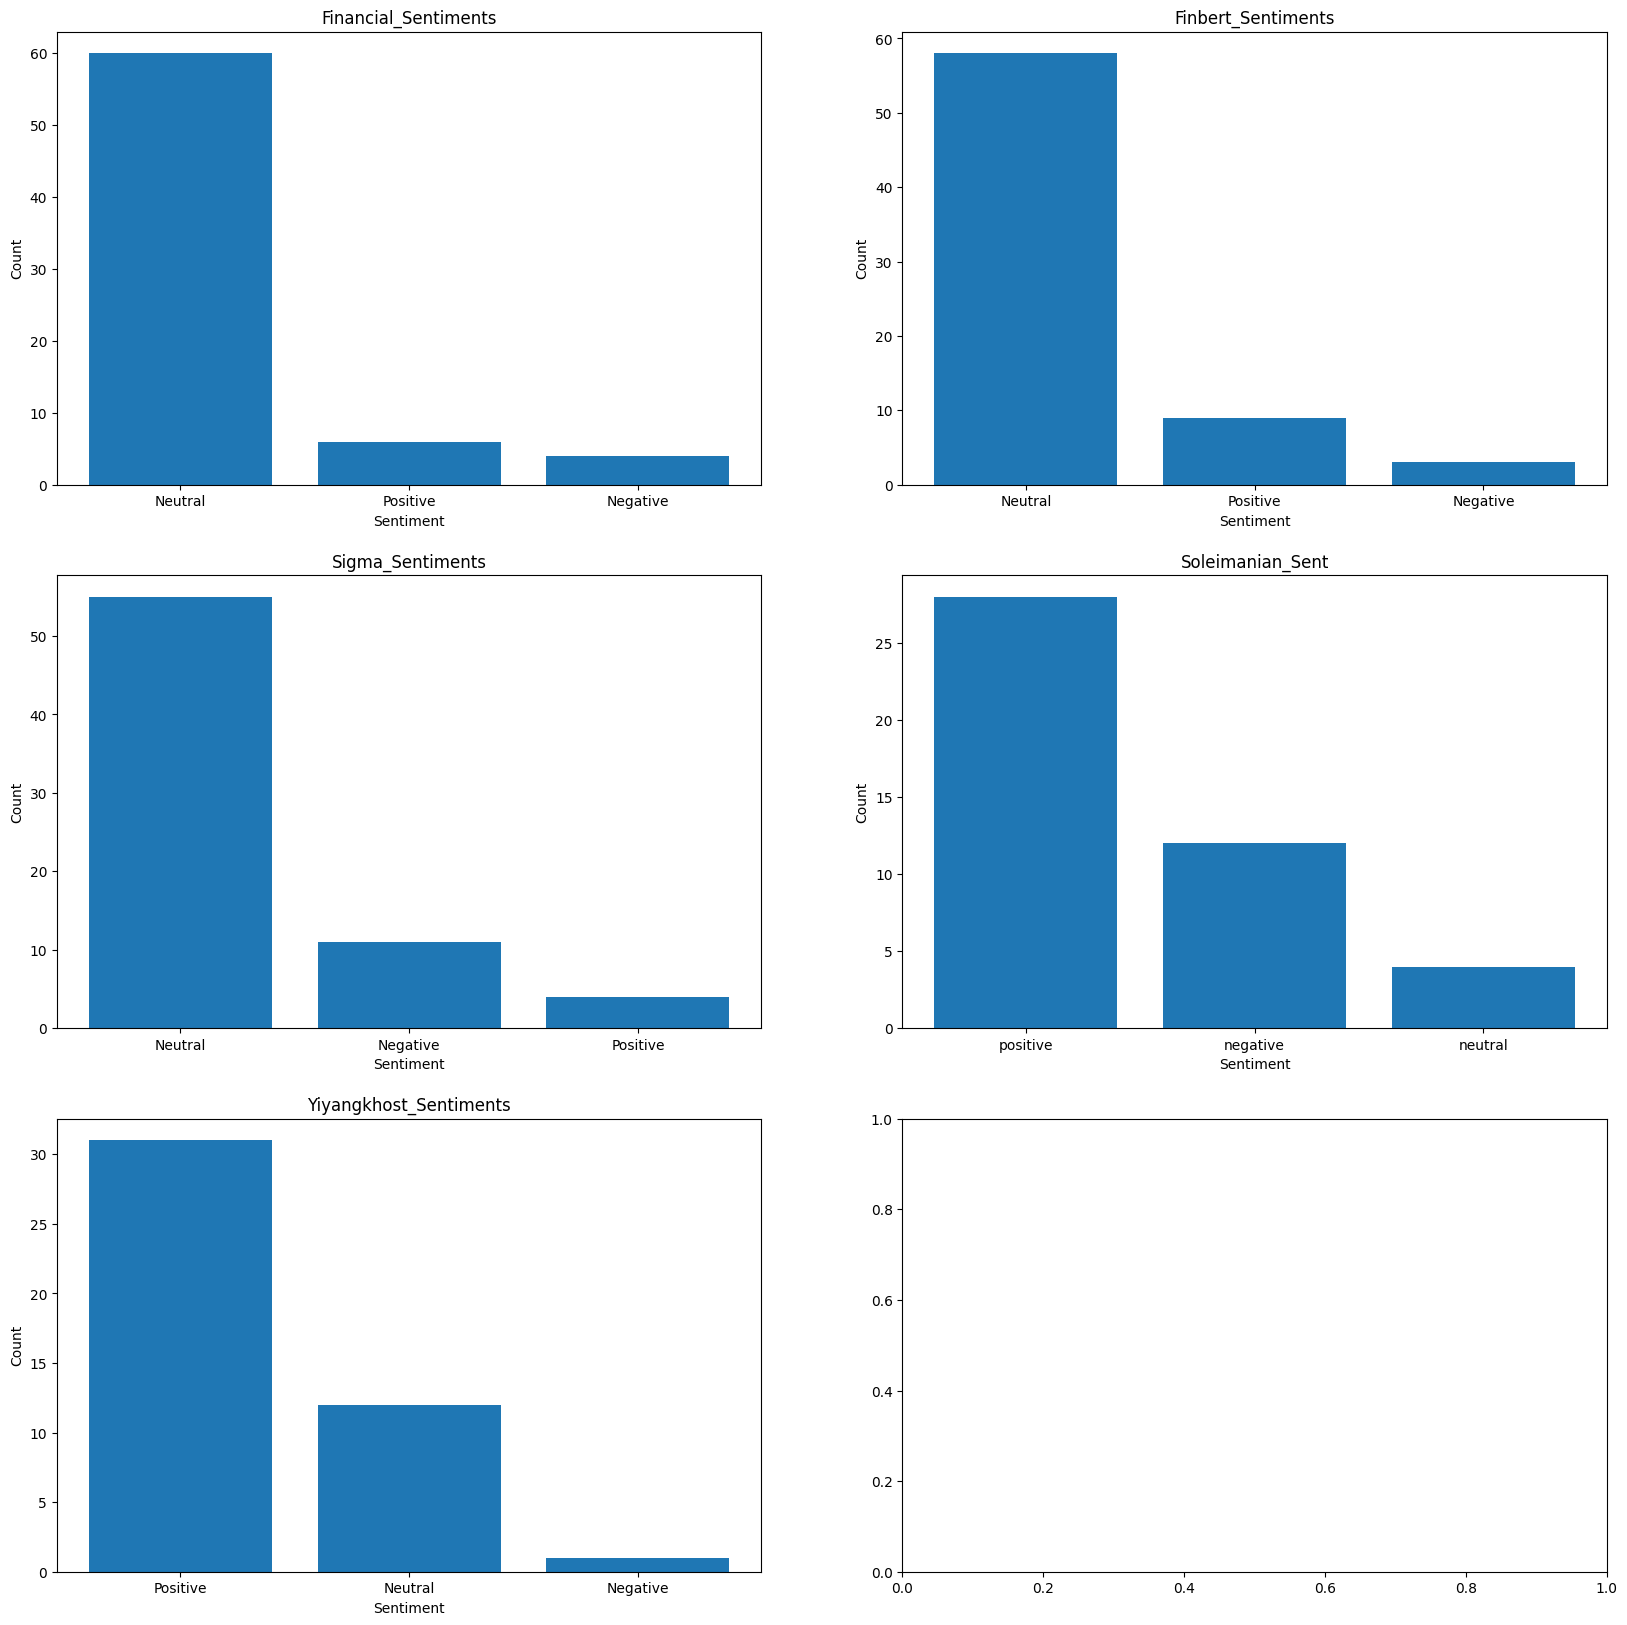

In [157]:
plt.subplots(3,2, figsize=(20, 20))

models = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]
models_name = ['Financial_Sentiments', 'Finbert_Sentiments', 'Sigma_Sentiments', 'Soleimanian_Sent', 'Yiyangkhost_Sentiments']

# plot bar plot for each model

for i in range(len(models)):
  plt.subplot(3, 2, i+1)
  plt.bar(models[i]['sentiment'].value_counts().index, models[i]['sentiment'].value_counts().values)
  plt.title(models_name[i])
  plt.xlabel('Sentiment')
  plt.ylabel('Count')
  
            

In [158]:
map_dict = {
  "Neutral": 0,
  "Positive": 1,
  "Negative": -1,
  'neutral' : 0,
  'positive' : 1,
  'negative' : -1
}
# Encode the sentiment labels
dataframes = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]

for dataframe in dataframes : 
    dataframe['sentiment'] = dataframe['sentiment'].map(map_dict)


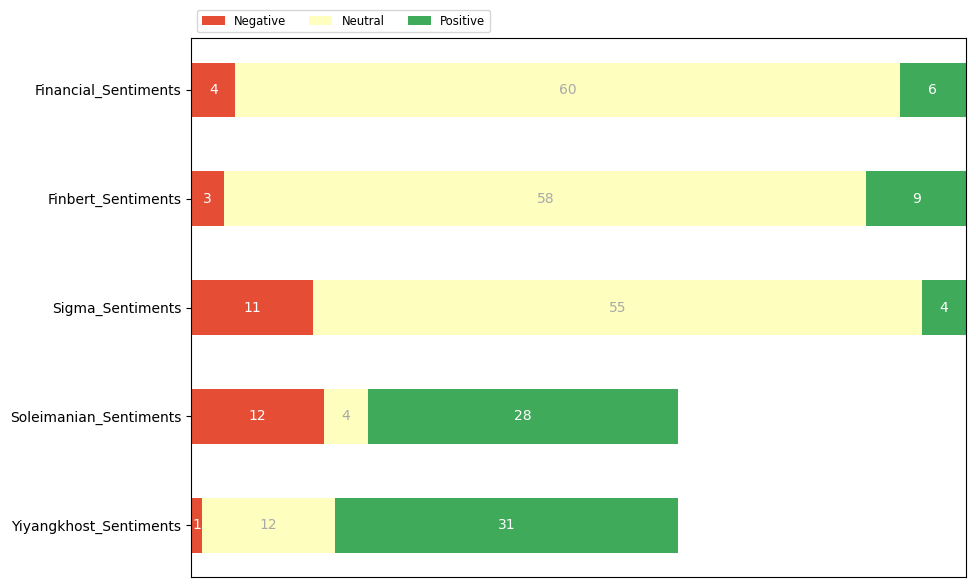

In [166]:
import matplotlib.pyplot as plt
import numpy as np


category_names = ['Negative', 'Neutral', 'Positive']

models_name = ['Financial_Sentiments', 'Finbert_Sentiments', 'Sigma_Sentiments', 'Soleimanian_Sentiments', 'Yiyangkhost_Sentiments']
models = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]

results = dict()

for i in range(len(models)):
  # make it so that it will follow the order
  model_list = []
  model_dict = models[i]['sentiment'].value_counts().to_dict()
  model_list.append(model_dict[-1]); model_list.append(model_dict[0]); model_list.append(model_dict[1])
  results[models_name[i]] = model_list

def horizontalStackedBar(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
 
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


horizontalStackedBar(results, category_names)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


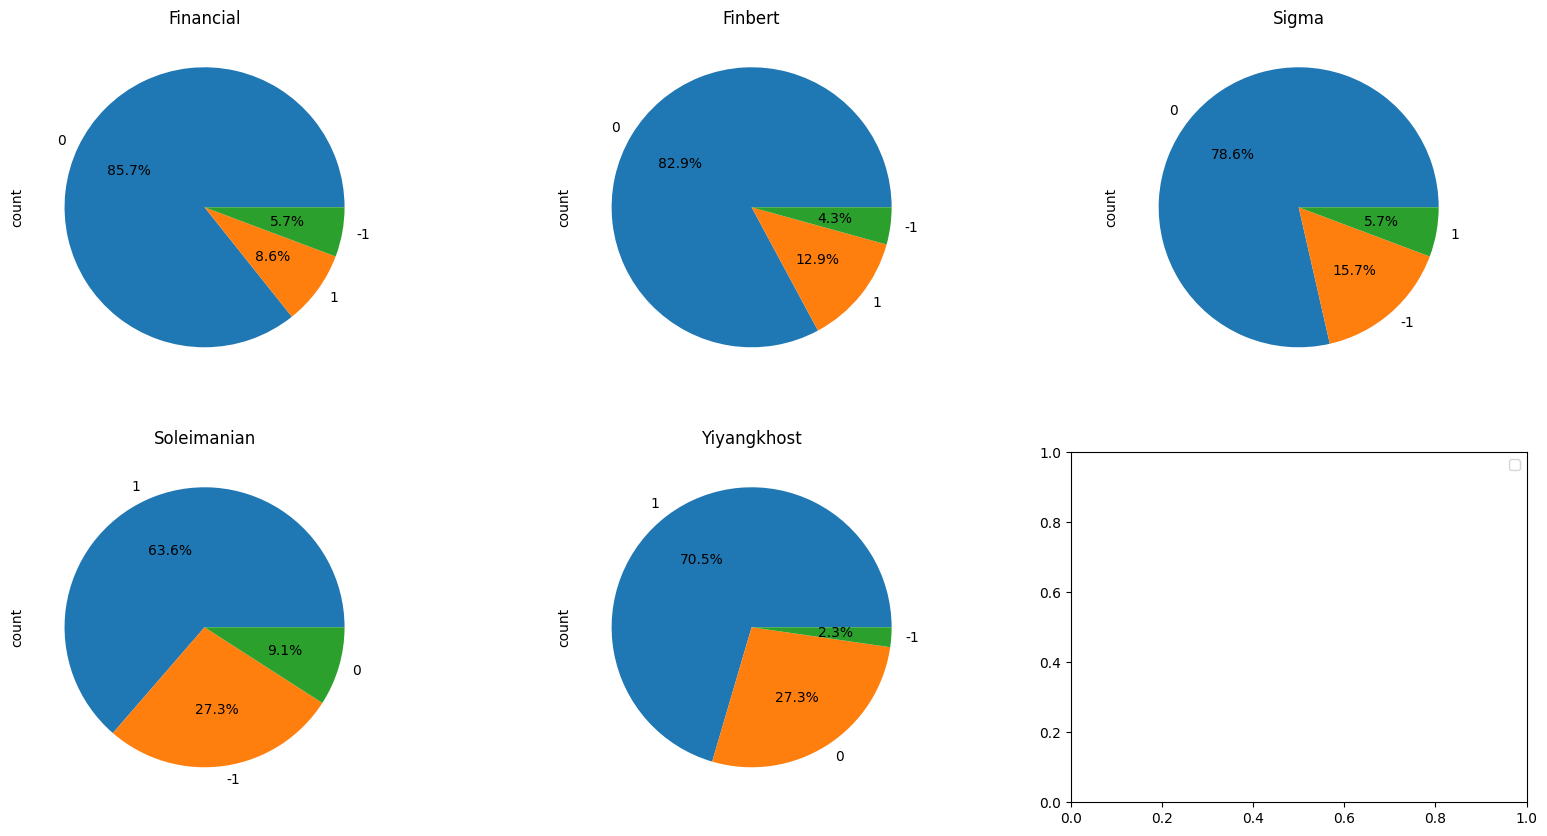

In [160]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

# make a pie chart for each dataframe
dataframes = [financial_sentiments, finbert_sentiments, sigma_sentiments, soleimanian_sentiments, yiyangkhost_sentiments]
titles = ['Financial', 'Finbert', 'Sigma', 'Soleimanian', 'Yiyangkhost']

for i, df in enumerate(dataframes):
  row = i // 3
  col = i % 3
  df['sentiment'].value_counts().plot(kind='pie', ax=ax[row, col], autopct='%1.1f%%')
  ax[row][col].set_title(titles[i])

ax[1][2].legend()

<Axes: >

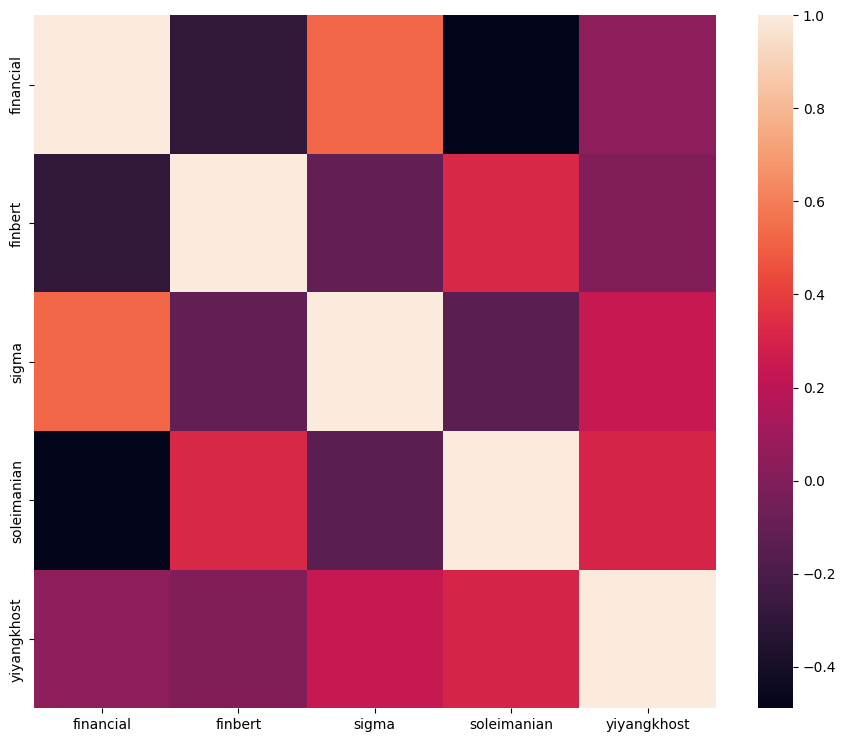

In [161]:
# make a heatmap comparing all the dataframes 'sentiment'
import seaborn as sns

df_corr = pd.DataFrame(
  {
    'financial': financial_sentiments['sentiment'],
    'finbert': finbert_sentiments['sentiment'],
    'sigma': sigma_sentiments['sentiment'],
    'soleimanian': soleimanian_sentiments['sentiment'],
    'yiyangkhost': yiyangkhost_sentiments['sentiment']
  }
)

corr = df_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr)


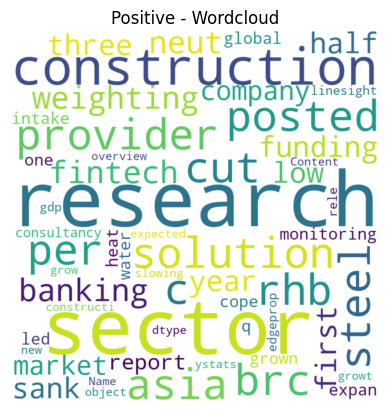

In [162]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

positive_financial = financial_sentiments[financial_sentiments['sentiment'] == 1]
positive_finbert = finbert_sentiments[finbert_sentiments['sentiment'] == 1]
positive_sigma = sigma_sentiments[sigma_sentiments['sentiment'] == 1]

# create a new dataframe
positive_dataframe = pd.concat([positive_financial, positive_finbert, positive_sigma])

positive_dataframe.dropna(inplace=True)

positive_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(''.join(str(positive_dataframe['Content'])))

plt.figure()
plt.title("Positive - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


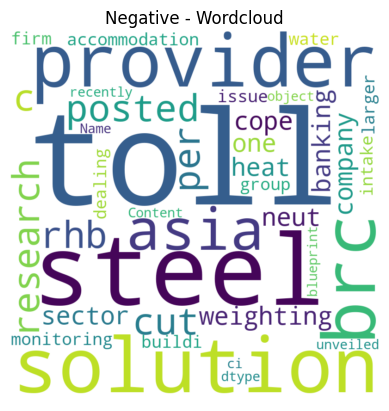

In [163]:
negative_financial = financial_sentiments[financial_sentiments['sentiment'] == -1]
negative_finbert = finbert_sentiments[finbert_sentiments['sentiment'] == -1]
negative_sigma = sigma_sentiments[sigma_sentiments['sentiment'] == -1]

negative_dataframe = pd.concat([negative_financial, negative_finbert, negative_sigma])
negative_dataframe.dropna(inplace=True)

negative_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(''.join(str(negative_dataframe['Content'])))

plt.figure()
plt.title("Negative - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

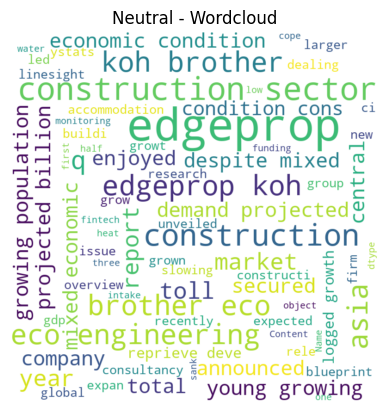

In [164]:
neutral_financial = financial_sentiments[financial_sentiments['sentiment'] == 0]
neutral_finbert = finbert_sentiments[finbert_sentiments['sentiment'] == 0]
neutral_sigma = sigma_sentiments[sigma_sentiments['sentiment'] == 0]

neutral_dataframe = pd.concat([neutral_financial, neutral_finbert, neutral_sigma])
neutral_dataframe.dropna(inplace=True)

neutral_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(''.join(str(neutral_dataframe['Content'])))
plt.figure()
plt.title("Neutral - Wordcloud")
plt.imshow(neutral_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
